## Preprocessing Conversor

Para poder procesar el modelo pegar los archivos en la carpeta correspondiente y luego correr la funcion para modificar los nombres de los archivos

In [4]:
def conversor():
    """
    Funcion utilizada para convertir los archivos en el formato requerido por nnUNet
    """
    import os

    # Set the directory path containing the files to be renamed
    dir_path = ''

    # Set the starting and ending file numbers
    start_num = 0
    end_num = 1666

    # Set the starting and new file name formats for each file type
    file_formats = {
        't1': ('BraTS2021_{0:05}_t1.nii.gz', 'BraTS2020_{0:05}_0000.nii.gz'),
        't1ce': ('BraTS2021_{0:05}_t1ce.nii.gz', 'BraTS2020_{0:05}_0001.nii.gz'),
        't2': ('BraTS2021_{0:05}_t2.nii.gz', 'BraTS2020_{0:05}_0002.nii.gz'),
        'flair': ('BraTS2021_{0:05}_flair.nii.gz', 'BraTS2020_{0:05}_0003.nii.gz')
    }

    # Loop through each file number and file type, and rename the files
    for i in range(start_num, end_num+1):
        for file_type, file_format in file_formats.items():
            starting_filename = file_format[0].format(i)
            new_filename = file_format[1].format(i)
            starting_filepath = os.path.join(dir_path, starting_filename)
            new_filepath = os.path.join(dir_path, new_filename)
            if os.path.exists(starting_filepath):
                os.rename(starting_filepath, new_filepath)

In [3]:
conversor()

# Coeficiente de DICE y Hausdorff para las observaciones de Train

Controlamos el coeficiente de DICE y el de Jaccard para las observaciones en las cuales se corrio el modelo

In [1]:
# Load sample images
import nibabel as nib
import numpy as np
pred = nib.load('')
gt = nib.load('')


In [2]:
print("Image dimensions: ")
print(gt.shape)
print(pred.shape)

print("Image spacing: ")
print(gt.header.get_zooms())
print(pred.header.get_zooms())

Image dimensions: 
(240, 240, 155)
(240, 240, 155)
Image spacing: 
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)


In [4]:
import numpy as np
from medpy.metric.binary import dc, hd

# First, we get the numpy matrix from the Nibabel image
gt_data = gt.get_fdata()
pred_data = pred.get_fdata()

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Background", "Edema", "Necrosis", "Enhancing Tumor"]
gt_labels = [0, 2, 1, 4]
pred_labels = [0, 1, 2, 3]

# Initialize arrays to store the Dice coefficient and Hausdorff distance for each class
dice_coefficients = np.zeros(len(class_names))
hausdorff_distances_pixels = np.zeros(len(class_names))
hausdorff_distances_mm = np.zeros(len(class_names))

# Compute the Dice coefficient and Hausdorff distance for each class
for i, class_name in enumerate(class_names):
    gt_label = gt_labels[i]
    pred_label = pred_labels[i]

    binary_gt = (gt_data == gt_label).astype(np.uint8)
    binary_pred = (pred_data == pred_label).astype(np.uint8)

    dice_coefficients[i] = dc(binary_pred, binary_gt)
    hausdorff_distances_pixels[i] = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
    hausdorff_distances_mm[i] = hd(binary_pred, binary_gt, voxelspacing=gt.header.get_zooms(), connectivity=1)

# Print the results for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Dice coefficient: {dice_coefficients[i]}")
    print(f"Hausdorff distance (in pixels): {hausdorff_distances_pixels[i]}")
    print(f"Hausdorff distance (in millimeters): {hausdorff_distances_mm[i]}")
    print()


Class: Background
Dice coefficient: 0.9997176433050871
Hausdorff distance (in pixels): 61.0
Hausdorff distance (in millimeters): 61.0

Class: Edema
Dice coefficient: 0.9487516685618234
Hausdorff distance (in pixels): 65.01538279515087
Hausdorff distance (in millimeters): 65.01538279515087

Class: Necrosis
Dice coefficient: 0.9691332231164725
Hausdorff distance (in pixels): 5.0990195135927845
Hausdorff distance (in millimeters): 5.0990195135927845

Class: Enhancing Tumor
Dice coefficient: 0.947840462905559
Hausdorff distance (in pixels): 43.05810028322197
Hausdorff distance (in millimeters): 43.05810028322197



## Boxplot

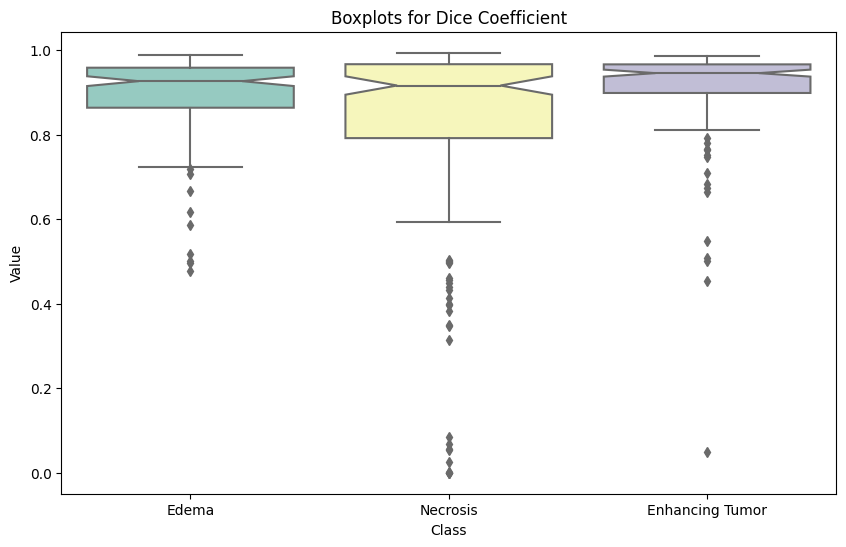

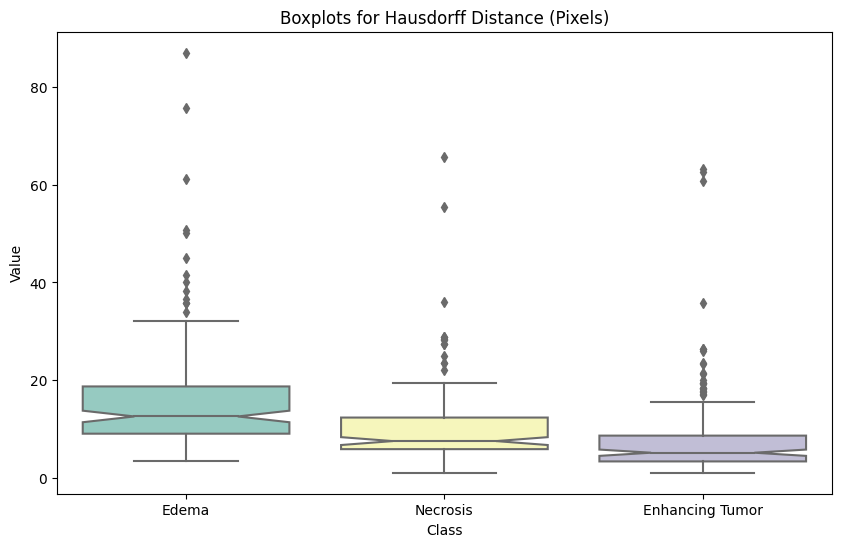

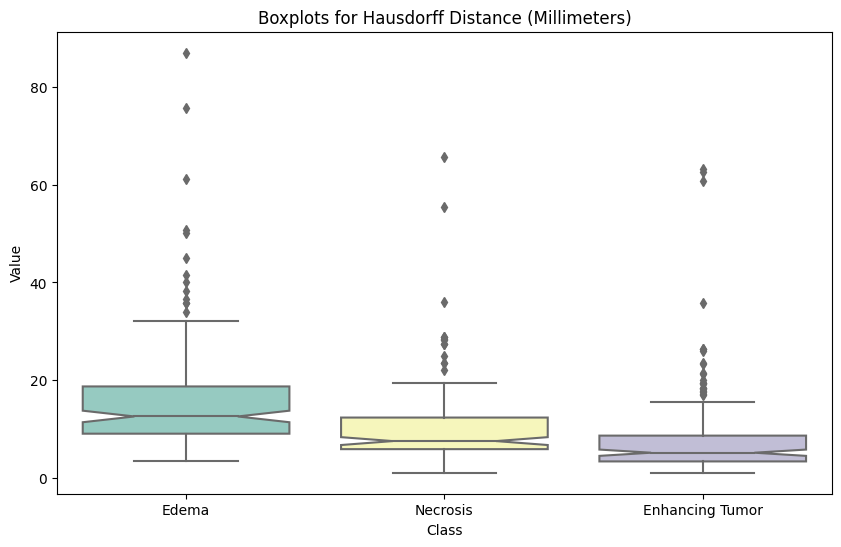

In [6]:
import numpy as np
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from medpy.metric.binary import dc, hd

# Define the directories for ground truth and predicted files
gt_dir = ''
pred_dir = ''

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Edema", "Necrosis", "Enhancing Tumor"]
gt_labels = [2, 1, 4]
pred_labels = [1, 2, 3]

# Initialize lists to store the metrics for each class
dice_coefficients = [[] for _ in range(len(class_names))]
hausdorff_distances_pixels = [[] for _ in range(len(class_names))]
hausdorff_distances_mm = [[] for _ in range(len(class_names))]

# Find the matching files in both directories
gt_files = glob.glob(os.path.join(gt_dir, 'BraTS2021_*.nii.gz'))
pred_files = glob.glob(os.path.join(pred_dir, 'BraTS2020_*.nii.gz'))

# Iterate over the matching files
for gt_path in gt_files:
    # Extract the file index from the ground truth file path
    file_index = int(os.path.basename(gt_path).split('_')[1])

    # Find the corresponding predicted file path
    pred_path = os.path.join(pred_dir, f'BraTS2020_{file_index:05}.nii.gz')

    # Load the ground truth and predicted masks
    gt_data = nib.load(gt_path).get_fdata()
    pred_data = nib.load(pred_path).get_fdata()

    # Compute the metrics for each class
    for i, class_name in enumerate(class_names):
        gt_label = gt_labels[i]
        pred_label = pred_labels[i]

        if gt_label == 0 or pred_label == 0:
            continue

        binary_gt = (gt_data == gt_label).astype(np.uint8)
        binary_pred = (pred_data == pred_label).astype(np.uint8)

        # Check if either mask is empty
        if np.sum(binary_gt) == 0 or np.sum(binary_pred) == 0:
            continue

        dice_coefficient = dc(binary_pred, binary_gt)
        hausdorff_distance_pixels = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
        hausdorff_distance_mm = hd(binary_pred, binary_gt, voxelspacing=nib.load(gt_path).header.get_zooms(), connectivity=1)

        dice_coefficients[i].append(dice_coefficient)
        hausdorff_distances_pixels[i].append(hausdorff_distance_pixels)
        hausdorff_distances_mm[i].append(hausdorff_distance_mm)

# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()

In [11]:
class_names = ["Edema", "Combined Tumor", "Enhancing Tumor"]

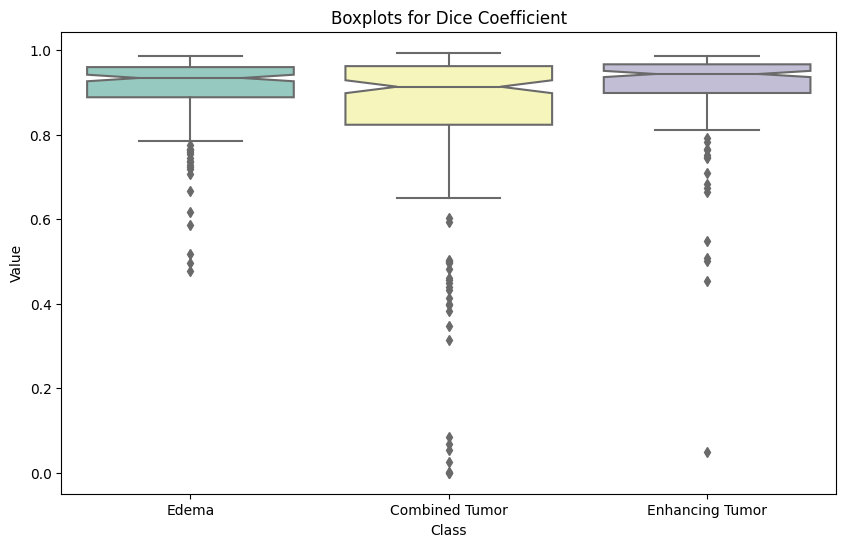

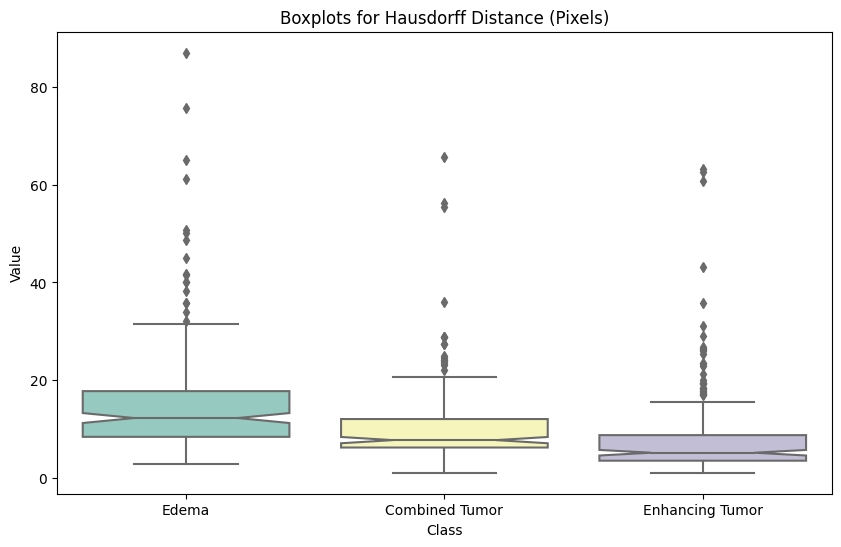

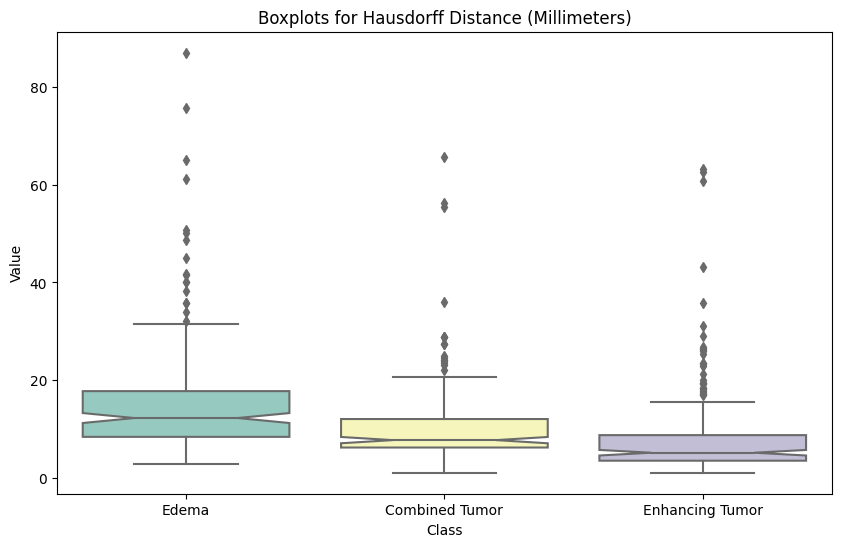

In [12]:
# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()

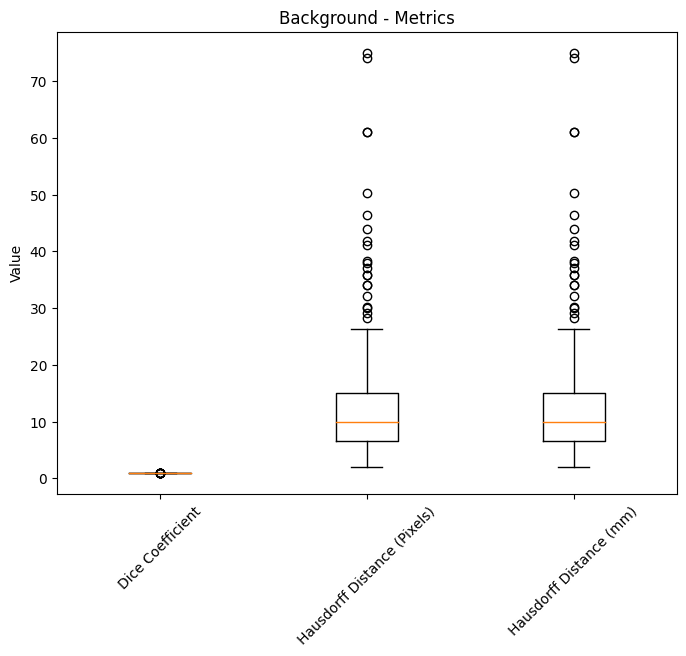

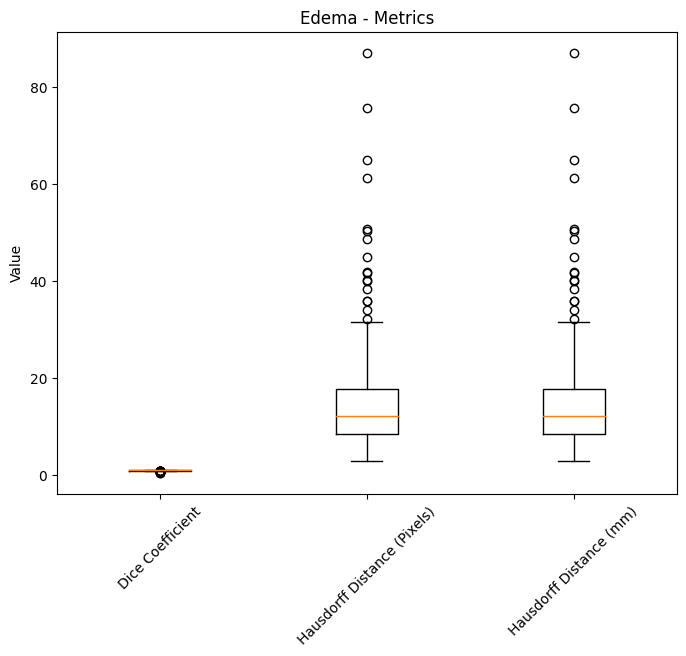

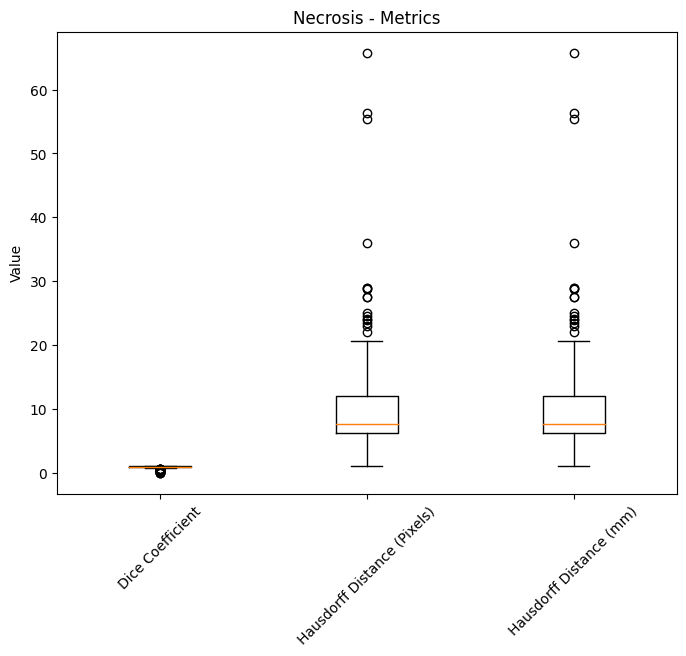

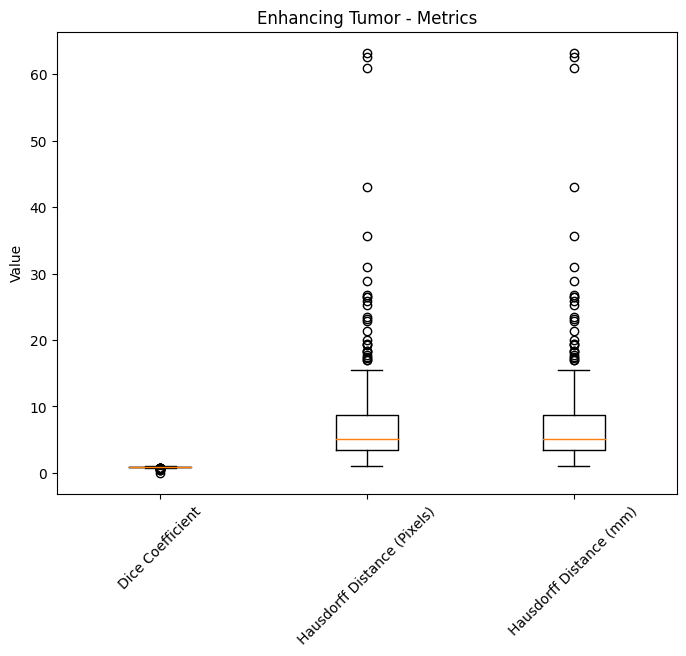

In [3]:
import numpy as np
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
from medpy.metric.binary import dc, hd

# Define the directories for ground truth and predicted files
gt_dir = ''
pred_dir = ''

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Background", "Edema", "Necrosis", "Enhancing Tumor"]
gt_labels = [0, 2, 1, 4]
pred_labels = [0, 1, 2, 3]

# Initialize lists to store the metrics for each class
dice_coefficients = [[] for _ in range(len(class_names))]
hausdorff_distances_pixels = [[] for _ in range(len(class_names))]
hausdorff_distances_mm = [[] for _ in range(len(class_names))]

# Find the matching files in both directories
gt_files = glob.glob(os.path.join(gt_dir, 'BraTS2021_*.nii.gz'))
pred_files = glob.glob(os.path.join(pred_dir, 'BraTS2020_*.nii.gz'))

# Iterate over the matching files
for gt_path in gt_files:
    # Extract the file index from the ground truth file path
    file_index = int(os.path.basename(gt_path).split('_')[1])

    # Find the corresponding predicted file path
    pred_path = os.path.join(pred_dir, f'BraTS2020_{file_index:05}.nii.gz')

    # Load the ground truth and predicted masks
    gt_data = nib.load(gt_path).get_fdata()
    pred_data = nib.load(pred_path).get_fdata()

    # Compute the metrics for each class
    for i, class_name in enumerate(class_names):
        gt_label = gt_labels[i]
        pred_label = pred_labels[i]

        binary_gt = (gt_data == gt_label).astype(np.uint8)
        binary_pred = (pred_data == pred_label).astype(np.uint8)

        # Check if either mask is empty
        if np.sum(binary_gt) == 0 or np.sum(binary_pred) == 0:
            continue

        dice_coefficient = dc(binary_pred, binary_gt)
        hausdorff_distance_pixels = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
        hausdorff_distance_mm = hd(binary_pred, binary_gt, voxelspacing=nib.load(gt_path).header.get_zooms(), connectivity=1)

        dice_coefficients[i].append(dice_coefficient)
        hausdorff_distances_pixels[i].append(hausdorff_distance_pixels)
        hausdorff_distances_mm[i].append(hausdorff_distance_mm)

# Plot boxplots for each class and metric
metrics = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]
metric_labels = ['Dice Coefficient', 'Hausdorff Distance (Pixels)', 'Hausdorff Distance (mm)']

for i, class_name in enumerate(class_names):
    plt.figure(figsize=(8, 6))
    plt.boxplot([metric[i] for metric in metrics])
    plt.xticks(range(1, len(metric_labels) + 1), metric_labels, rotation=45)
    plt.title(f'{class_name} - Metrics')
    plt.ylabel('Value')
    plt.show()

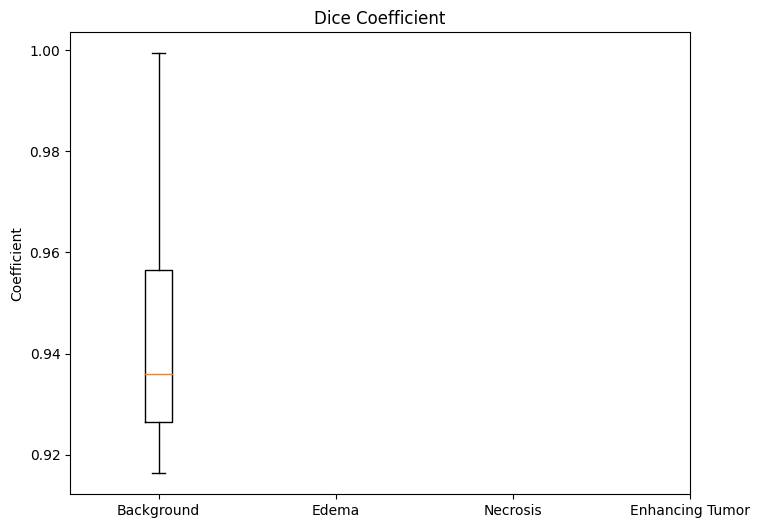

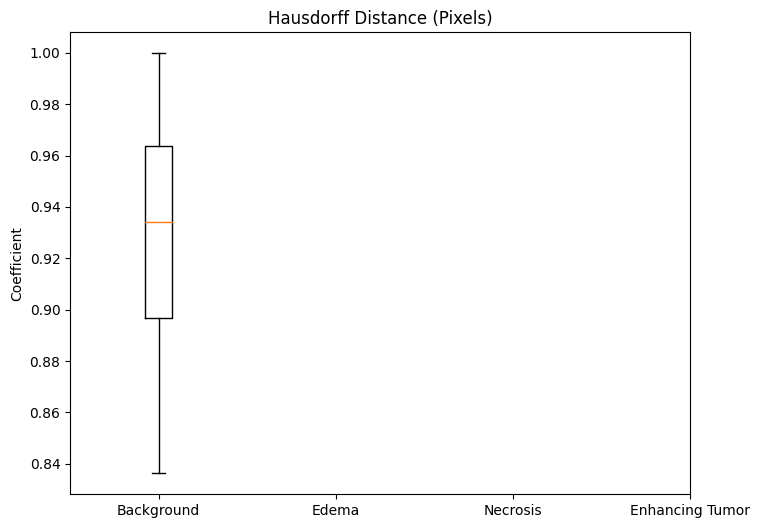

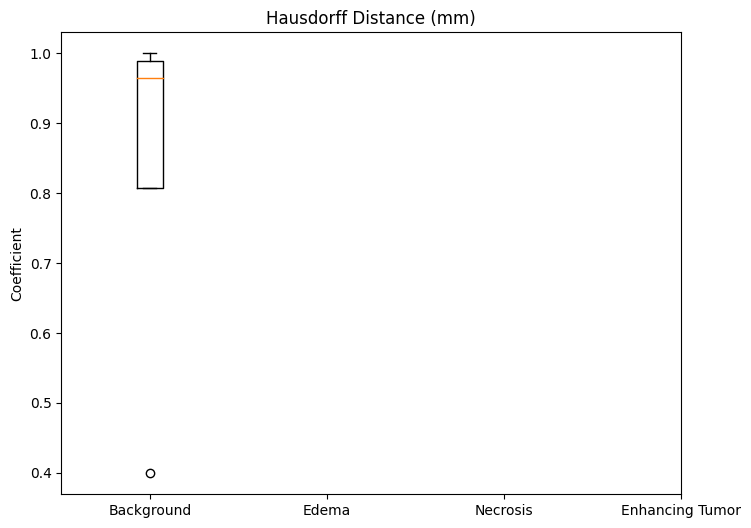

In [42]:
import matplotlib.pyplot as plt

# Define the class names
class_names = ["Background", "Edema", "Necrosis", "Enhancing Tumor"]

# List of metric names
metric_names = ['Dice Coefficient', 'Hausdorff Distance (Pixels)', 'Hausdorff Distance (mm)']

# Plot the coefficients for each class
for i, metric in enumerate(metric_names):
    plt.figure(figsize=(8, 6))
    plt.boxplot([coefficients[i] for coefficients in dice_coefficients])
    plt.xticks(range(1, len(class_names) + 1), class_names)
    plt.title(metric)
    plt.ylabel('Coefficient')
    plt.show()

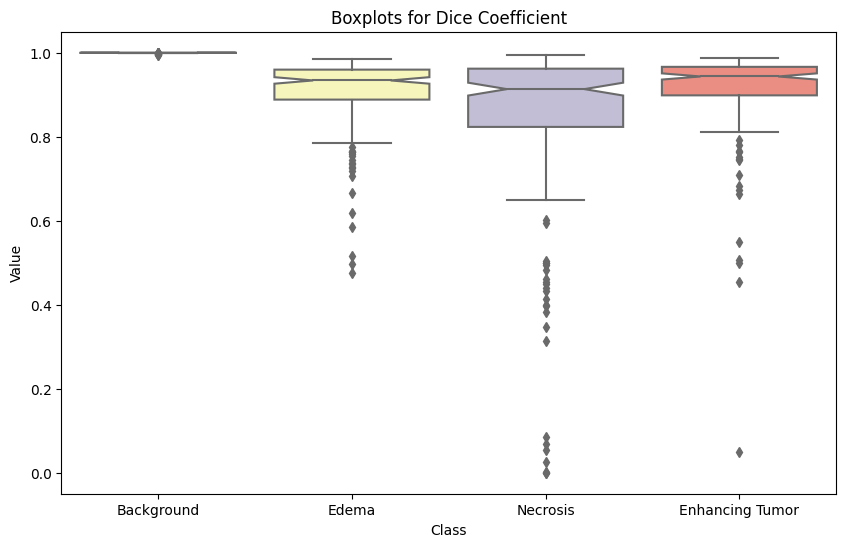

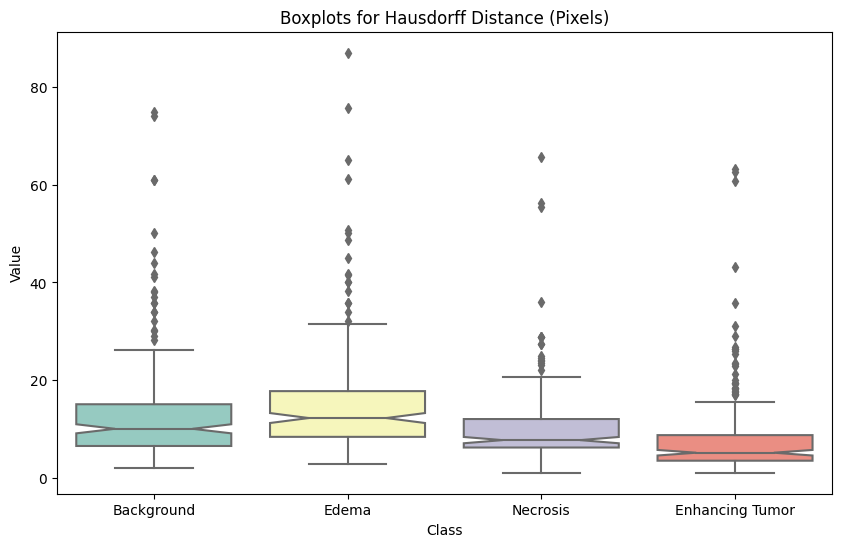

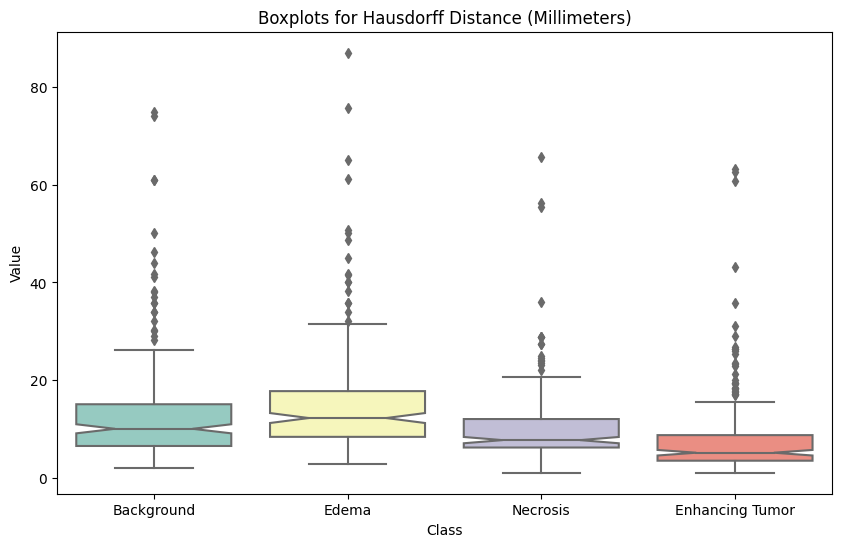

In [6]:
import seaborn as sns
# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()

## Conversion de DICOM a NIFTI

In [1]:
import dicom2nifti
import os

path_out_data = ""

path_one_patient = ""

dicom2nifti.dicom_series_to_nifti(path_one_patient, os.path.join(path_out_data, ''))

{'NII_FILE': '/home/amatys/code/data/glioma_bajo/wunderlicheliana_0000.nii.gz',
 'NII': <nibabel.nifti1.Nifti1Image at 0x7ffb254f43d0>,
 'MAX_SLICE_INCREMENT': 6.999985846996275}

## PREVIO

- Fusionar etiquetas como lo hace enzo en su script con el mask DONE
- Correr Dice devuelta + Hausdorff DONE
- Mandar las imagenes del gt fusionado + las de prediccion, para que compare si tiene sentido. DONE
- Fusionar y cambiar labels en brats para mandar, mandar esto tambien.
- Glioma Bajo.

## Dice Coefficient + Hausdorff Distance - Glioma Alto

File: 00017, Class: Edema, Dice: 0.7241, HD (Pixels): 10.82, HD (mm): 10.82
File: 00017, Class: Combined Tumor, Dice: 0.5651, HD (Pixels): 11.79, HD (mm): 11.79
File: 00017, Class: Enhancing Tumor, Dice: 0.8519, HD (Pixels): 6.48, HD (mm): 6.48
File: 00016, Class: Edema, Dice: 0.4145, HD (Pixels): 44.84, HD (mm): 44.84
File: 00016, Class: Combined Tumor, Dice: 0.5259, HD (Pixels): 22.91, HD (mm): 22.91
File: 00016, Class: Enhancing Tumor, Dice: 0.7518, HD (Pixels): 11.05, HD (mm): 11.05
File: 00003, Class: Edema, Dice: 0.8336, HD (Pixels): 9.70, HD (mm): 9.70
File: 00003, Class: Combined Tumor, Dice: 0.4554, HD (Pixels): 10.86, HD (mm): 10.86
File: 00003, Class: Enhancing Tumor, Dice: 0.8521, HD (Pixels): 4.24, HD (mm): 4.24
File: 00015, Class: Edema, Dice: 0.8356, HD (Pixels): 14.07, HD (mm): 14.07
File: 00015, Class: Combined Tumor, Dice: 0.4648, HD (Pixels): 11.18, HD (mm): 11.18
File: 00015, Class: Enhancing Tumor, Dice: 0.8226, HD (Pixels): 5.83, HD (mm): 5.83
File: 00011, Class: 

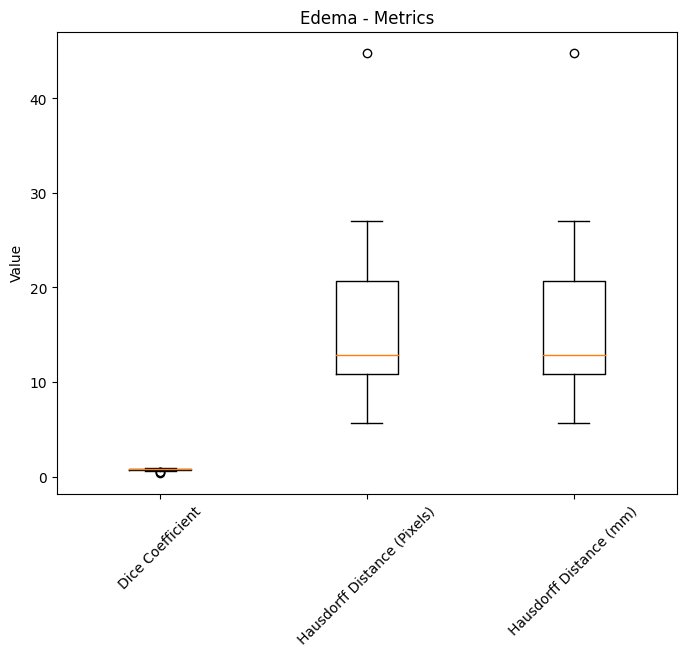

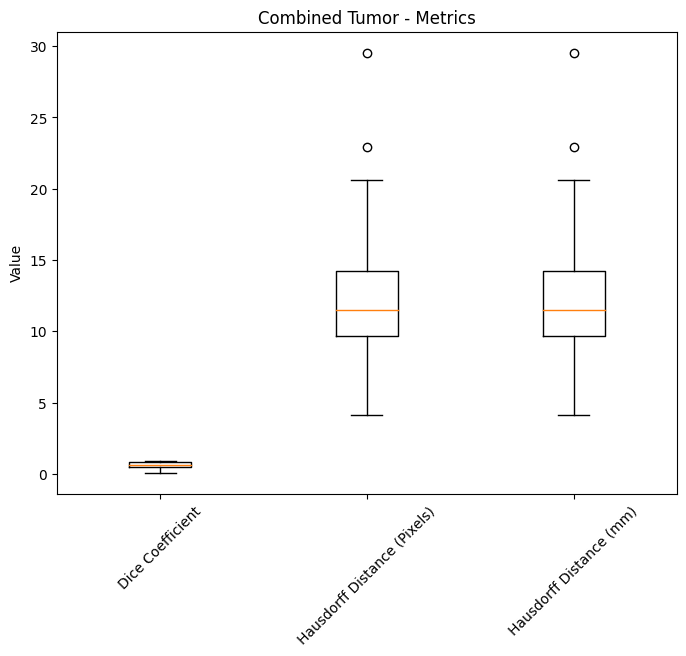

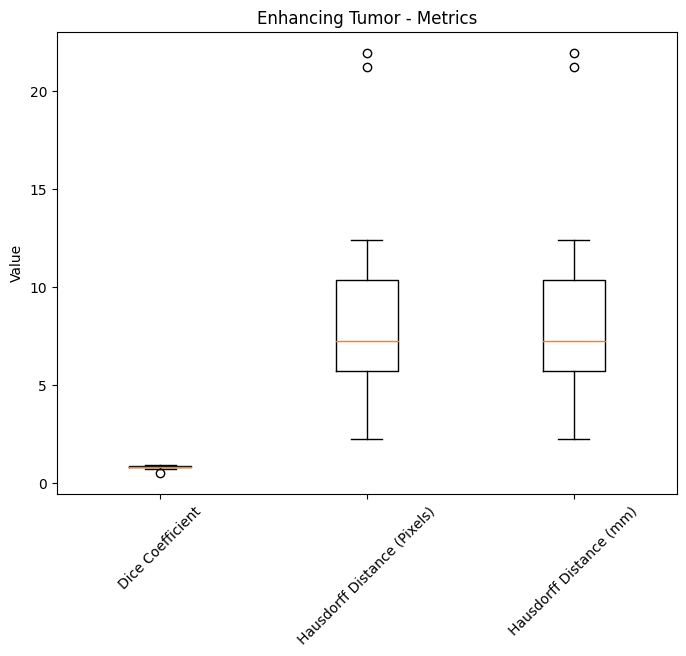

In [3]:
import numpy as np
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
from medpy.metric.binary import dc, hd

# Define the directories for ground truth and predicted files
gt_dir = ''
pred_dir = ''

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Edema", "Combined Tumor", "Enhancing Tumor"]
gt_labels = [1, 2, 3, 4]
pred_labels = [1, 2, 3, 2]

# Initialize lists to store the metrics for each class
dice_coefficients = [[] for _ in range(len(class_names))]
hausdorff_distances_pixels = [[] for _ in range(len(class_names))]
hausdorff_distances_mm = [[] for _ in range(len(class_names))]

# Find the matching files in both directories
gt_files = glob.glob(os.path.join(gt_dir, '*.nii.gz'))
pred_files = glob.glob(os.path.join(pred_dir, '*.nii.gz'))

# Iterate over the matching files
for gt_path in gt_files:
    # Load the ground truth mask
    gt_data = nib.load(gt_path).get_fdata()

    # Extract the file index from the ground truth file path
    file_index = os.path.basename(gt_path).split('_')[-1].split('.')[0]

    # Find the corresponding predicted file path
    pred_path = [p for p in pred_files if file_index in p][0]

    # Load the predicted mask
    pred_data = nib.load(pred_path).get_fdata()

    # Merge label 2 and 4 as label 2 in the gt_labels
    gt_data[(gt_data == 4)] = 2

    # Compute the metrics for each class
    for i, class_name in enumerate(class_names):
        gt_label = gt_labels[i]
        pred_label = pred_labels[i]

        # Skip background class
        if gt_label == 0:
            continue

        binary_gt = (gt_data == gt_label).astype(np.uint8)
        binary_pred = (pred_data == pred_label).astype(np.uint8)

         # Check if either mask is empty
        if np.sum(binary_gt) == 0 or np.sum(binary_pred) == 0:
            continue

        dice_coefficient = dc(binary_pred, binary_gt)

        if np.sum(binary_pred) > 0 and np.sum(binary_gt) > 0:
            hausdorff_distance_pixels = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
            hausdorff_distance_mm = hd(binary_pred, binary_gt, voxelspacing=nib.load(gt_path).header.get_zooms(), connectivity=1)
        else:
            hausdorff_distance_pixels = 0
            hausdorff_distance_mm = 0

        dice_coefficients[i].append(dice_coefficient)
        hausdorff_distances_pixels[i].append(hausdorff_distance_pixels)
        hausdorff_distances_mm[i].append(hausdorff_distance_mm)

        print(f'File: {file_index}, Class: {class_name}, Dice: {dice_coefficient:.4f}, HD (Pixels): {hausdorff_distance_pixels:.2f}, HD (mm): {hausdorff_distance_mm:.2f}')

# Plot boxplots for each class and metric
metrics = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]
metric_labels = ['Dice Coefficient', 'Hausdorff Distance (Pixels)', 'Hausdorff Distance (mm)']

for i, class_name in enumerate(class_names):
    # Skip background class
    if gt_labels[i] == 0:
        continue

    plt.figure(figsize=(8, 6))
    plt.boxplot([metric[i] for metric in metrics])
    plt.xticks(range(1, len(metric_labels) + 1), metric_labels, rotation=45)
    plt.title(f'{class_name} - Metrics')
    plt.ylabel('Value')
    plt.show()


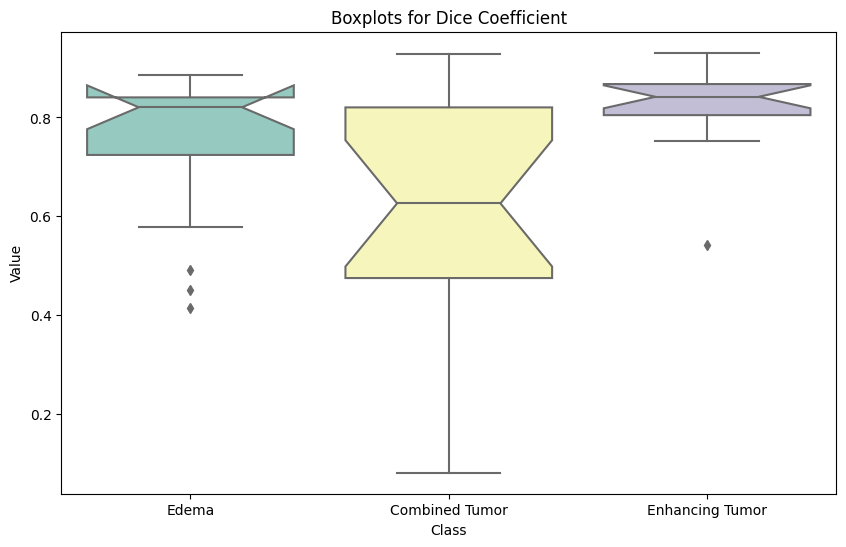

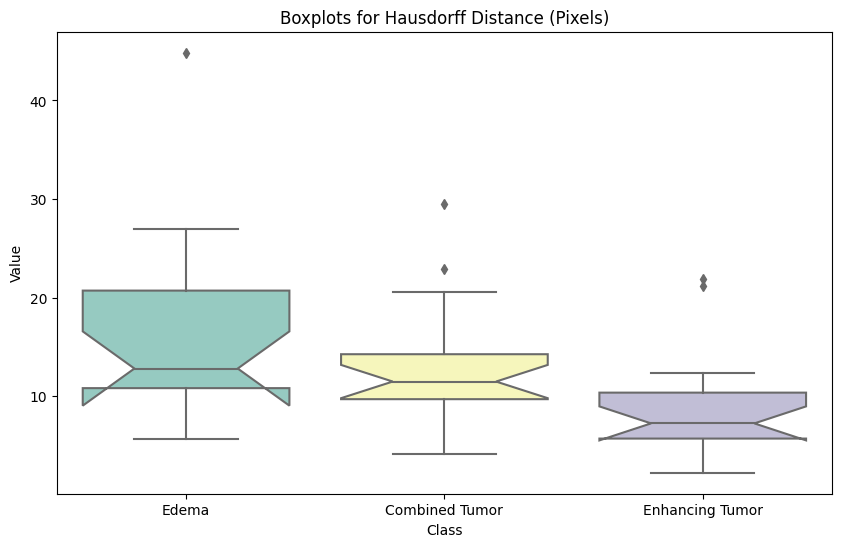

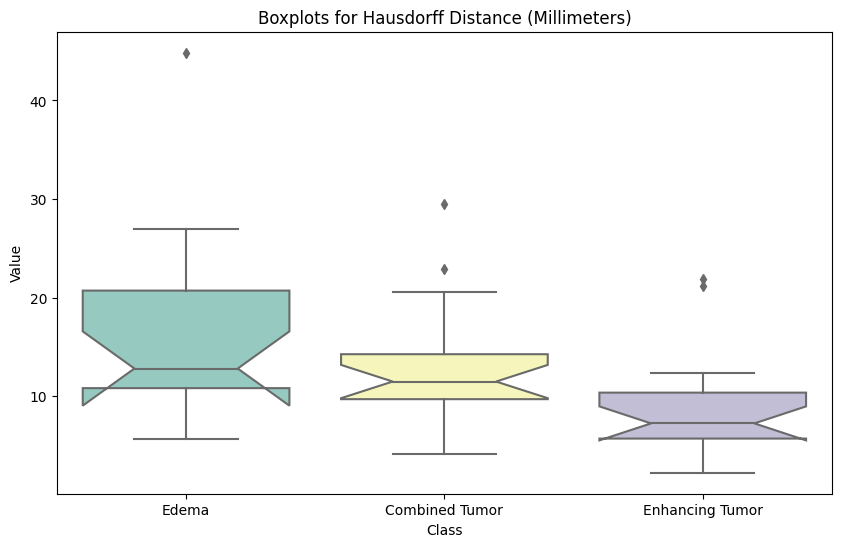

In [4]:
import seaborn as sns

# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()

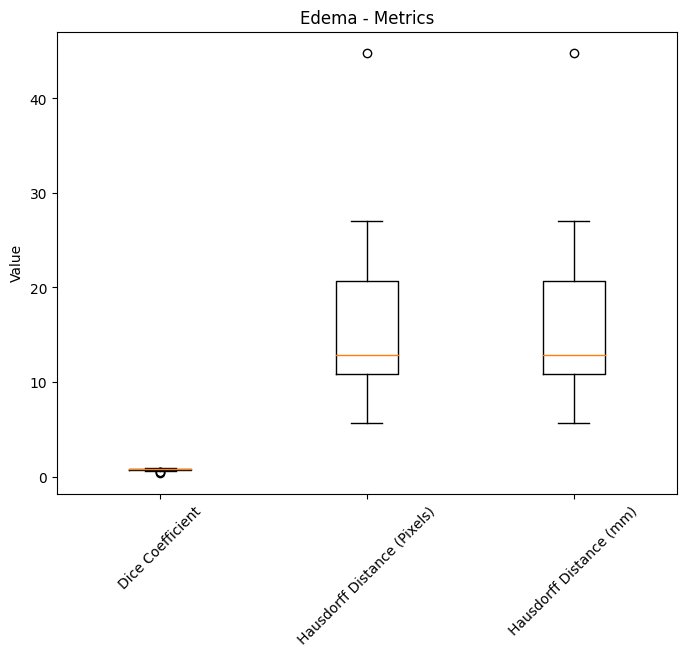

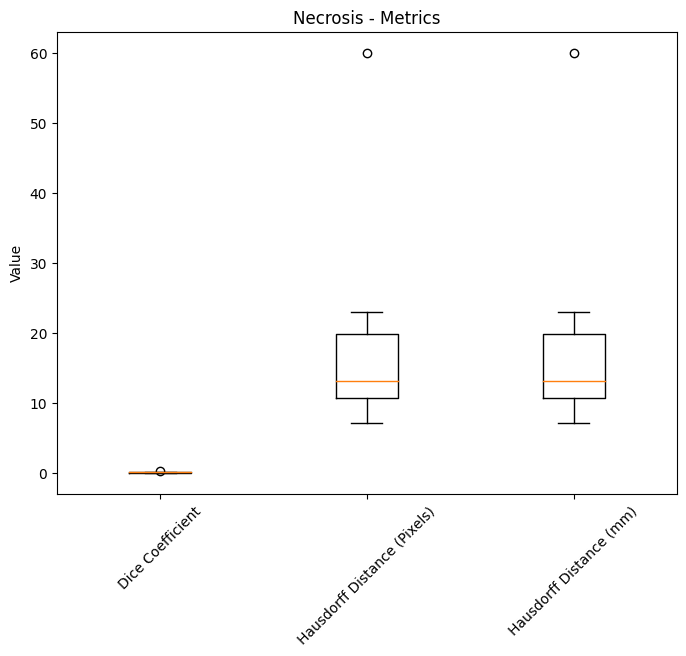

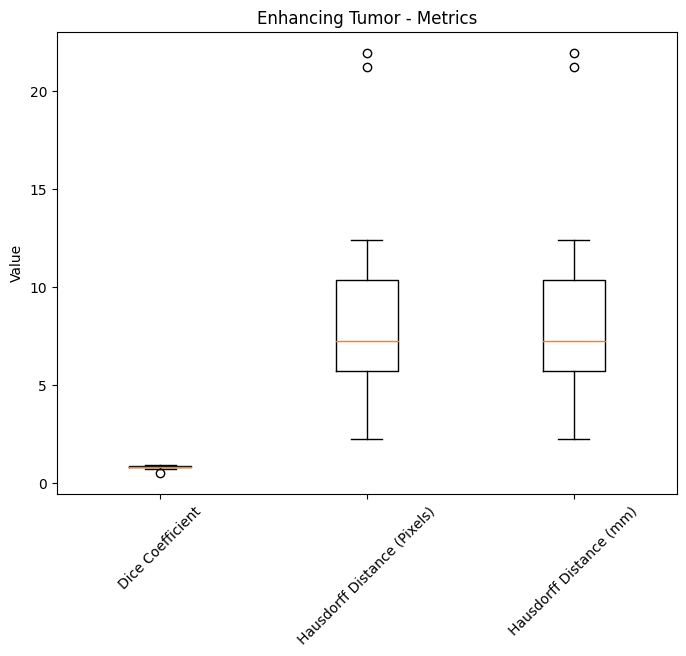

In [3]:
import numpy as np
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
from medpy.metric.binary import dc, hd

# Define the directories for ground truth and predicted files
gt_dir = ''
pred_dir = ''

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Edema", "Necrosis", "Enhancing Tumor"]
gt_labels = [1, 2, 3, 4]
pred_labels = [1, 2, 3, 2]

# Initialize lists to store the metrics for each class
dice_coefficients = [[] for _ in range(len(class_names))]
hausdorff_distances_pixels = [[] for _ in range(len(class_names))]
hausdorff_distances_mm = [[] for _ in range(len(class_names))]

# Find the matching files in both directories
gt_files = glob.glob(os.path.join(gt_dir, '*.nii.gz'))
pred_files = glob.glob(os.path.join(pred_dir, '*.nii.gz'))

# Iterate over the matching files
for gt_path in gt_files:
    # Load the ground truth mask
    gt_data = nib.load(gt_path).get_fdata()

    # Extract the file index from the ground truth file path
    file_index = os.path.basename(gt_path).split('_')[-1].split('.')[0]

    # Find the corresponding predicted file path
    pred_path = [p for p in pred_files if file_index in p][0]

    # Load the predicted mask
    pred_data = nib.load(pred_path).get_fdata()

    # Compute the metrics for each class
    for i, class_name in enumerate(class_names):
        gt_label = gt_labels[i]
        pred_label = pred_labels[i]

        # Skip background class
        if gt_label == 0:
            continue

        binary_gt = (gt_data == gt_label).astype(np.uint8)
        binary_pred = (pred_data == pred_label).astype(np.uint8)

        # Check if either mask is empty
        if np.sum(binary_gt) == 0 and np.sum(binary_pred) == 0:
            continue

        dice_coefficient = dc(binary_pred, binary_gt)
        hausdorff_distance_pixels = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
        hausdorff_distance_mm = hd(binary_pred, binary_gt, voxelspacing=nib.load(gt_path).header.get_zooms(), connectivity=1)

        dice_coefficients[i].append(dice_coefficient)
        hausdorff_distances_pixels[i].append(hausdorff_distance_pixels)
        hausdorff_distances_mm[i].append(hausdorff_distance_mm)
        
        # AGREGAR PRINT CON NOMBRE DE ARCHIVO + DICE + HAUSDORFF

# Plot boxplots for each class and metric
metrics = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]
metric_labels = ['Dice Coefficient', 'Hausdorff Distance (Pixels)', 'Hausdorff Distance (mm)']

for i, class_name in enumerate(class_names):
    # Skip background class
    if gt_labels[i] == 0:
        continue

    plt.figure(figsize=(8, 6))
    plt.boxplot([metric[i] for metric in metrics])
    plt.xticks(range(1, len(metric_labels) + 1), metric_labels, rotation=45)
    plt.title(f'{class_name} - Metrics')
    plt.ylabel('Value')
    plt.show()


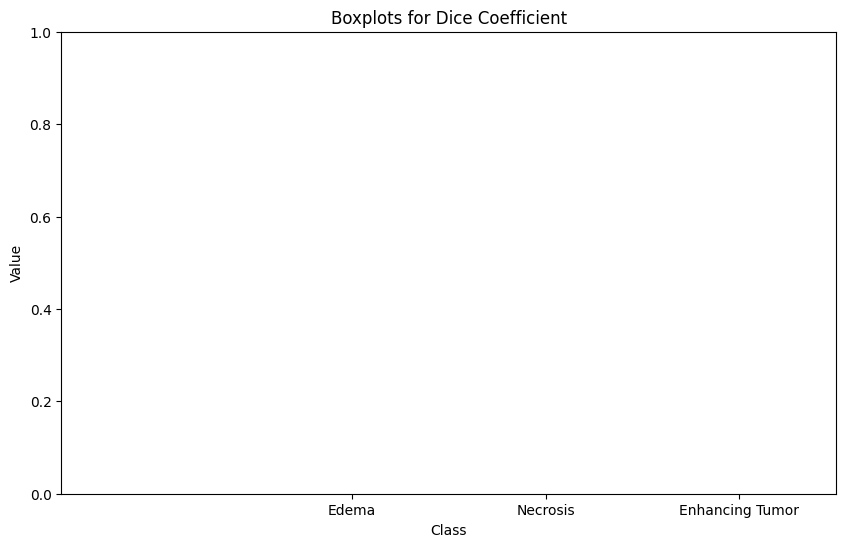

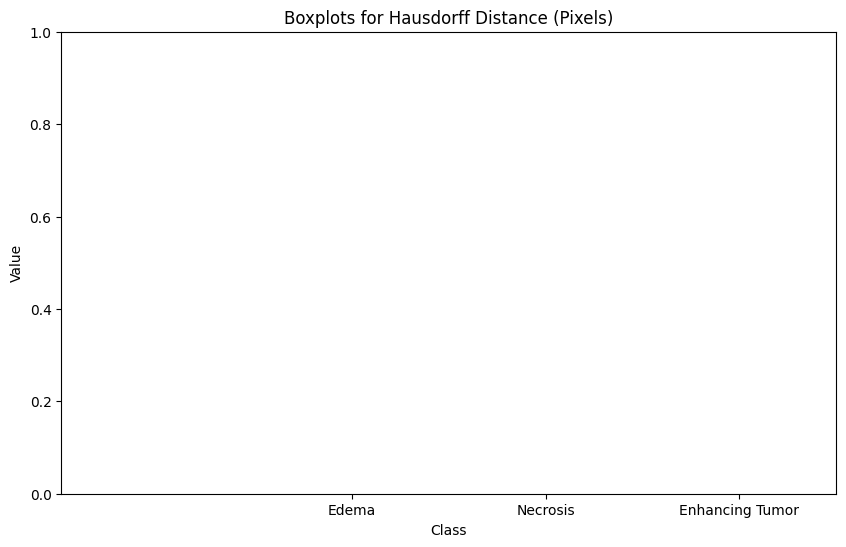

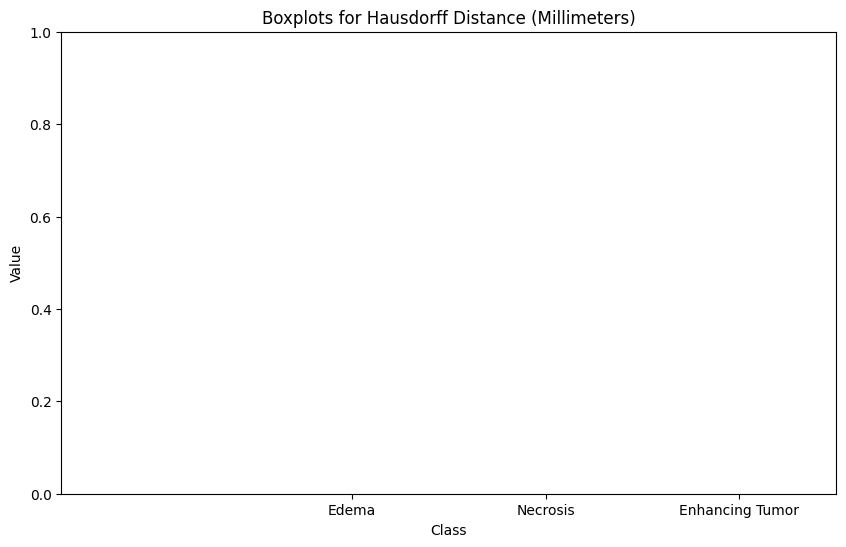

In [7]:
import seaborn as sns

# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    # Skip the first element in each list
    values = [val for val in values]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(1, len(class_names)), class_names[1:])  # Skip the first class name ('Background')
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()


In [6]:
import numpy as np
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from medpy.metric.binary import dc, hd

# Define the directories for ground truth and predicted files
gt_dir = ''
pred_dir = ''

# Define the class names and corresponding labels for ground truth and predicted masks
class_names = ["Background", "Edema", "Necrosis", "Enhancing Tumor"]
gt_labels = [0, 2, 1, 4]
pred_labels = [0, 1, 2, 3]

# Add label 4 to gt_labels, corresponding to label 2 in pred_labels
gt_labels.insert(3, 4)

# Initialize lists to store the metrics for each class
dice_coefficients = [[] for _ in range(len(class_names))]
hausdorff_distances_pixels = [[] for _ in range(len(class_names))]
hausdorff_distances_mm = [[] for _ in range(len(class_names))]

# Find the matching files in both directories
gt_files = glob.glob(os.path.join(gt_dir, '*.nii.gz'))
pred_files = glob.glob(os.path.join(pred_dir, '*.nii.gz'))

# Iterate over the matching files
for gt_path in gt_files:
    # Load the ground truth mask
    gt_data = nib.load(gt_path).get_fdata()

    # Extract the file index from the ground truth file path
    file_index = os.path.basename(gt_path).split('_')[-1].split('.')[0]

    # Find the corresponding predicted file path
    pred_path = [p for p in pred_files if file_index in p][0]

    # Load the predicted mask
    pred_data = nib.load(pred_path).get_fdata()

    # Compute the metrics for each class
    for i, class_name in enumerate(class_names):
        gt_label = gt_labels[i]
        pred_label = pred_labels[i]

        # Skip background class
        if gt_label == 0:
            continue

        binary_gt = (gt_data == gt_label).astype(np.uint8)
        binary_pred = (pred_data == pred_label).astype(np.uint8)

        # Check if either mask is empty
        if np.sum(binary_gt) == 0 or np.sum(binary_pred) == 0:
            continue

        dice_coefficient = dc(binary_pred, binary_gt)
        hausdorff_distance_pixels = hd(binary_pred, binary_gt, voxelspacing=None, connectivity=1)
        hausdorff_distance_mm = hd(binary_pred, binary_gt, voxelspacing=nib.load(gt_path).header.get_zooms(), connectivity=1)

        dice_coefficients[i].append(dice_coefficient)
        hausdorff_distances_pixels[i].append(hausdorff_distance_pixels)
        hausdorff_distances_mm[i].append(hausdorff_distance_mm)

# Create a list of metrics and corresponding data
metrics = ["Dice Coefficient", "Hausdorff Distance (Pixels)", "Hausdorff Distance (Millimeters)"]
data = [dice_coefficients, hausdorff_distances_pixels, hausdorff_distances_mm]

# Plot boxplots for each metric
for metric, values in zip(metrics, data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=values, notch=True, palette='Set3')
    plt.title(f"Boxplots for {metric}")
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel("Class")
    plt.ylabel("Value")
    plt.show()


IndexError: list index out of range

# Change Segmentation of Glioma Alto

In [ ]:
import os
import nibabel as nib
import numpy as np

def fuse_labels(segmentation_data):
    # Replace label 4 with label 2
    segmentation_data[segmentation_data == 4] = 2
    return segmentation_data

def process_segmentation_file(file_path):
    try:
        # Load NIfTI file
        nii_img = nib.load(file_path)
        segmentation_data = nii_img.get_fdata().astype(np.uint8)
        
        # Fuse labels
        processed_data = fuse_labels(segmentation_data)
        
        # Create a new NIfTI image with processed data
        processed_nii = nib.Nifti1Image(processed_data, nii_img.affine)
        
        # Save the new NIfTI image with a new file name
        new_file_name = os.path.basename(file_path).replace('.nii.gz', '_processed.nii.gz')
        new_file_path = os.path.join(output_folder, new_file_name)
        nib.save(processed_nii, new_file_path)
        
        print(f"Processed and saved: {new_file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Replace with the path to the folder containing your NIfTI files
input_folder = ''

# Replace with the path to the folder where you want to save the processed files
output_folder = ''

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all files in the input folder
input_files = [f for f in os.listdir(input_folder) if f.endswith('.nii.gz')]

# Process each segmentation file
for file_name in input_files:
    file_path = os.path.join(input_folder, file_name)
    process_segmentation_file(file_path)
